# Implementation of original transformer model as described by Vaswani et al for English to German translation

This is the implementation of the original transformer model described by Vaswani et al in the 
paper "Attention is all you need", trained for translation of English sentences to German, 
implemented using tensorflow and keras. It is trained on a small dataset consisting of about 
150000 English to German sentence pairs. It features all the elements described in the paper 
including Mulltihead Attention mechanism, Positional Encoding and a learning rate scheduler.
However due to limitations of computation resources and small size of dataset, the model 
currently does not provide accurate translation. But the reader may feel free to play with the 
model, suggest any improvements or train the model on a better training dataset

In [4]:
# Dataset Cleaning
import re
import string
from unicodedata import normalize
from numpy import array
from pickle import dump

def load_doc(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs
def clean_pairs(lines):
    cleaned = list()
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            line = line.split()
            line = [word.lower() for word in line]
            line = [word.translate(table) for word in line] # remove punctuations
            line = [re_print.sub('', w) for w in line] # remove non printable characters
            line = [word for word in line if word.isalpha()] # remove numbers
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
filename = 'data/deu.txt'
doc = load_doc(filename)
pairs = to_pairs(doc)
clean_pairs = clean_pairs(pairs)
save_clean_data(clean_pairs, 'data/english-german.pkl')

Saved: data/english-german.pkl


In [5]:
# Prepare dataset
from pickle import load, dump, HIGHEST_PROTOCOL
from numpy import savetxt
from pickle import load
from numpy.random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64

class PrepareDataset:
    def __init__(self, **kwargs):
        super(PrepareDataset, self).__init__(**kwargs)
        self.n_sentences = 12000
        self.train_split = 0.8
        self.val_split = 0.2

    def create_tokenizer(self, dataset):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(dataset)
        return tokenizer

    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)

    def find_vocab_size(self, tokenizer, dataset):
        tokenizer.fit_on_texts(dataset)
        return len(tokenizer.word_index) + 1

    def save_tokenizer(self, tokenizer_tuple, name):
        with open(f"tokenizer/{name}_tokenizer.pkl", 'wb') as handle:
            dump(tokenizer_tuple, handle, protocol=HIGHEST_PROTOCOL)

    def __call__(self, filename, **kwargs):
        clean_dataset = load(open(filename, 'rb'))
        dataset = clean_dataset[:self.n_sentences, :]
        for i in range(dataset[:, 0].size):
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"
        shuffle(dataset)
        train = dataset[:int(self.n_sentences * self.train_split)]
        val = dataset[int(self.n_sentences * self.train_split):int(self.n_sentences * self.train_split)+int(self.n_sentences * (self.val_split))]

        # Prepare tokenizer for the encoder input
        enc_tokenizer = self.create_tokenizer(train[:, 0])
        enc_seq_length = self.find_seq_length(train[:, 0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])

        # Encode and pad the input sequences
        trainX = enc_tokenizer.texts_to_sequences(train[:, 0])
        trainX = pad_sequences(trainX, maxlen=enc_seq_length, padding='post')
        trainX = convert_to_tensor(trainX, dtype=int64)

        # Prepare tokenizer for the decoder input
        dec_tokenizer = self.create_tokenizer(train[:, 1])
        dec_seq_length = self.find_seq_length(train[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])

        # Encode and pad the input sequences
        trainY = dec_tokenizer.texts_to_sequences(train[:, 1])
        trainY = pad_sequences(trainY, maxlen=dec_seq_length, padding='post')
        trainY = convert_to_tensor(trainY, dtype=int64)

        # Validation dataset
        valX = enc_tokenizer.texts_to_sequences(val[:, 0])
        valX = pad_sequences(valX, maxlen=enc_seq_length, padding='post')
        valX = convert_to_tensor(valX, dtype=int64)

        valY = dec_tokenizer.texts_to_sequences(val[:, 1])
        valY = pad_sequences(valY, maxlen=dec_seq_length, padding='post')
        valY = convert_to_tensor(valY, dtype=int64)

        # Save the encoder tokenizer
        self.save_tokenizer((enc_tokenizer, enc_seq_length, enc_vocab_size), 'enc')

        # Save the decoder tokenizer
        self.save_tokenizer((dec_tokenizer, dec_seq_length, dec_vocab_size), 'dec')

        return trainX, trainY, valX, valY, train, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size

In [6]:
# Multi Head Attention

import tensorflow as tf
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        #print(f"{type(self.d_k)}   {self.d_k}")
        #print(f"{type(mask)}   {mask}")
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, mask=mask, d_k=self.d_k)  #
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [7]:
# Position Embedding

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Layer
import numpy as np
'''
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices
'''
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [8]:
# Encoder

from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout
import keras

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        add = x + sublayer_x
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)
        return self.fully_connected2(self.activation(x_fc1))

# Implementing the Encoder Layer
@keras.saving.register_keras_serializable()
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training=training)

        return x

In [9]:
# Decoder

from tensorflow.keras.layers import Layer, Dropout
import tensorflow as tf

# Implementing the Decoder Layer
@tf.keras.utils.register_keras_serializable()
class DecoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.h = h
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model
        self.d_ff = d_ff
        self.rate = rate

        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = Dropout(rate)
        self.add_norm3 = AddNormalization()

    def build(self, input_shape):
        self.multihead_attention1 = MultiHeadAttention(self.h, self.d_k, self.d_v, self.d_model)
        self.dropout1 = Dropout(self.rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(self.h, self.d_k, self.d_v, self.d_model)
        self.dropout2 = Dropout(self.rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(self.d_ff, self.d_model)
        self.dropout3 = Dropout(self.rate)
        self.add_norm3 = AddNormalization()

    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):
        # Multi-head attention layer
        multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output1 = self.dropout1(multihead_output1, training=training)

        # Followed by an Add & Norm layer
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by another multi-head attention layer
        multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output, encoder_output, padding_mask)

        # Add in another dropout layer
        multihead_output2 = self.dropout2(multihead_output2, training=training)

        # Followed by another Add & Norm layer
        addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output2)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout3(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm3(addnorm_output2, feedforward_output)

# Implementing the Decoder
class Decoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        # Expected output shape = (number of sentences, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x = layer(x, encoder_output, lookahead_mask, padding_mask, training=training)
        return x

In [10]:
# Transformer Model

from tensorflow import math, cast, float32, linalg, ones, maximum, newaxis
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import keras

@keras.saving.register_keras_serializable()
class TransformerModel(Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
        self.model_last_layer = Dense(dec_vocab_size)

    def padding_mask(self, input):
        # Create mask which marks the zero padding values in the input by a 1.0
        mask = math.equal(input, 0)
        mask = cast(mask, float32)

        # The shape of the mask should be broadcastable to the shape
        # of the attention weights that it will be masking later on
        return mask[:, newaxis, newaxis, :]

    def lookahead_mask(self, shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
        return mask

    def call(self, encoder_input, decoder_input, training):
        # Create padding mask to mask the encoder inputs and the encoder outputs in the decoder
        enc_padding_mask = self.padding_mask(encoder_input)

        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = maximum(dec_in_padding_mask, dec_in_lookahead_mask)

        encoder_output = self.encoder(encoder_input, enc_padding_mask, training=training)
        decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training=training)
        model_output = self.model_last_layer(decoder_output)

        return model_output

In [11]:
# Training

import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.metrics import Mean
from tensorflow import data, train, math, reduce_sum, cast, equal, argmax, float32, GradientTape, TensorSpec, function, int64
from keras.losses import sparse_categorical_crossentropy
from time import time
from sys import stdout

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

epochs = 12
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Implementing a learning rate scheduler
class LRScheduler(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(LRScheduler, self).__init__(**kwargs)
        self.d_model = cast(d_model, float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)
dataset = PrepareDataset()
trainX, trainY, valX, valY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('data/english-german.pkl')

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

val_dataset = data.Dataset.from_tensor_slices((valX, valY))
val_dataset = val_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

# Loss function
def loss_fcn(target, prediction):
    padding_mask = math.logical_not(equal(target, 0))
    padding_mask = cast(padding_mask, float32)
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask
    return reduce_sum(loss) / reduce_sum(padding_mask)

# Accuracy function
def accuracy_fcn(target, prediction):
    padding_mask = math.logical_not(equal(target, 0))
    accuracy = equal(target, argmax(prediction, axis=2))
    accuracy = math.logical_and(padding_mask, accuracy)
    padding_mask = cast(padding_mask, float32)
    accuracy = cast(accuracy, float32)
    return reduce_sum(accuracy) / reduce_sum(padding_mask)

# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
val_loss = Mean(name='val_loss')
val_accuracy = Mean(name='val_accuracy')

ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
val_loss_dict = {}
train_accuracy_dict = {}
val_accuracy_dict = {}

# Speeding up the training process
@tf.function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        prediction = training_model(encoder_input, decoder_input, training=True)
        loss = loss_fcn(decoder_output, prediction)
        accuracy = accuracy_fcn(decoder_output, prediction)

    gradients = tape.gradient(loss, training_model.trainable_weights) #calculate gradients
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights)) # Update trainable parameters
    train_loss(loss)
    train_accuracy(accuracy)

start_time = time()
try:
    for epoch in range(epochs):
        train_loss.reset_state()
        train_accuracy.reset_state()

        print("\nStart of epoch %d" % (epoch + 1))

        for step, (train_batchX, train_batchY) in enumerate(train_dataset):
            encoder_input = train_batchX[:, 1:]
            decoder_input = train_batchY[:, :-1]
            decoder_output = train_batchY[:, 1:]
            train_step(encoder_input, decoder_input, decoder_output)

            if step % 50 == 0:
                print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
                stdout.flush()
                # print("Samples so far: %s" % ((step + 1) * batch_size))

        # Run a validation step after every epoch of training
        if (epoch+1)%1==0:
            val_loss.reset_state()
            val_accuracy.reset_state()
            for val_batchX, val_batchY in val_dataset:
                # Define the encoder and decoder inputs, and the decoder output
                encoder_input = val_batchX[:, 1:]
                decoder_input = val_batchY[:, :-1]
                decoder_output = val_batchY[:, 1:]

                # Generate a prediction
                prediction = training_model(encoder_input, decoder_input, training=False)

                # Compute the validation loss
                loss = loss_fcn(decoder_output, prediction)
                accuracy = accuracy_fcn(decoder_output, prediction)
                val_loss(loss)
                val_accuracy(accuracy)
            val_loss_dict[epoch+1] = val_loss.result()
            val_accuracy_dict[epoch+1] = val_accuracy.result()

            # Print epoch number and accuracy and loss values at the end of every epoch
            print("Epoch %d: Training Accuracy %.4f, Validation Accuracy %.4f" % (epoch+1, train_accuracy.result(), val_accuracy.result()))
        else:
            print("Epoch %d: Training Accuracy %.4f" % (epoch+1, train_accuracy.result()))

        train_loss_dict[epoch+1] = train_loss.result()
        train_accuracy_dict[epoch+1] = train_accuracy.result()

        # Save a checkpoint after each epoch
        if (epoch+1) % 1 == 0:
            save_path = ckpt_manager.save()
            training_model.save_weights(f"model_weights/epoch{epoch+1}.ckpt")
            print("Checkpoint saved at %s" % (save_path))
            print("Weights saved at %s" % (f"model_weights/epoch{epoch+1}.ckpt"))
            stdout.flush()

except KeyboardInterrupt:
    print("Training stopped")

print("Total time taken: %.2f min" % ((float(time()-start_time))/60.0))
print()
training_model.summary()


Start of epoch 1
Epoch 1 Step 0 Loss 8.4670 Accuracy 0.0000
Epoch 1 Step 50 Loss 7.6963 Accuracy 0.1234
Epoch 1 Step 100 Loss 7.0784 Accuracy 0.1695
Epoch 1: Training Accuracy 0.1908, Validation Accuracy 0.2638
Checkpoint saved at ./checkpoints/ckpt-1
Weights saved at model_weights/epoch1.ckpt

Start of epoch 2
Epoch 2 Step 0 Loss 5.6056 Accuracy 0.2876
Epoch 2 Step 50 Loss 5.4511 Accuracy 0.2669
Epoch 2 Step 100 Loss 5.2847 Accuracy 0.2747
Epoch 2: Training Accuracy 0.2836, Validation Accuracy 0.3047
Checkpoint saved at ./checkpoints/ckpt-2
Weights saved at model_weights/epoch2.ckpt

Start of epoch 3
Epoch 3 Step 0 Loss 4.6207 Accuracy 0.3344
Epoch 3 Step 50 Loss 4.6204 Accuracy 0.3290
Epoch 3 Step 100 Loss 4.5219 Accuracy 0.3437
Epoch 3: Training Accuracy 0.3553, Validation Accuracy 0.3885
Checkpoint saved at ./checkpoints/ckpt-3
Weights saved at model_weights/epoch3.ckpt

Start of epoch 4
Epoch 4 Step 0 Loss 4.1215 Accuracy 0.4047
Epoch 4 Step 50 Loss 4.1009 Accuracy 0.3943
Epoch 4

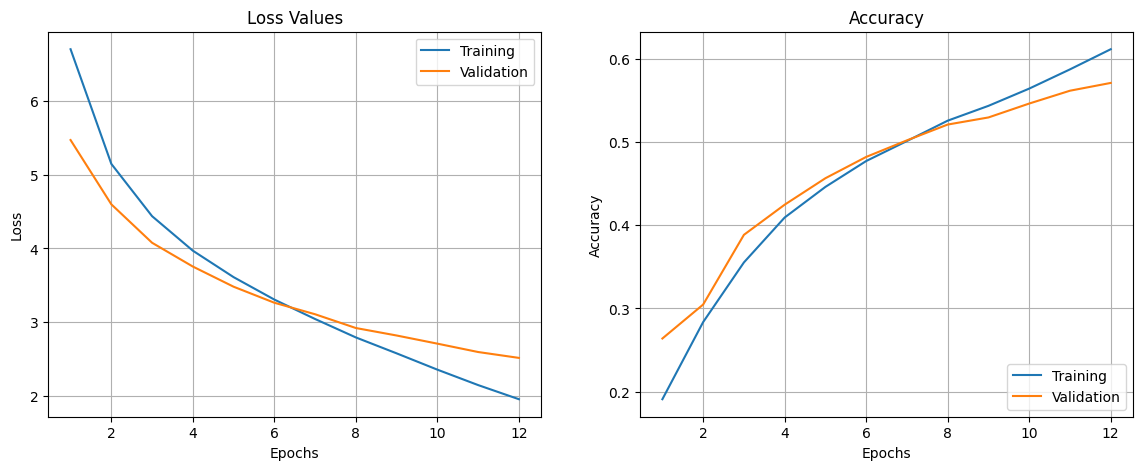

In [12]:
# Plotting loss curves

import matplotlib.pyplot as plt
from numpy import arange

train_values = train_loss_dict.values()
val_values = val_loss_dict.values()
train_accuracy_values = train_accuracy_dict.values()
val_accuracy_values = val_accuracy_dict.values()
# Generate a sequence of integers to represent the epoch numbers
epochs = train_loss_dict.keys()
val_epochs = val_loss_dict.keys()
#plt.style.use('dark_background')

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
xd = np.array([])
yd = np.array([])

ax[0].plot(epochs, train_values, label="Training Loss")
ax[0].plot(val_epochs, val_values, label="Validation Loss")
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Loss Values')
ax[0].legend(["Training", "Validation"], loc="upper right")
ax[0].grid()

ax[1].plot(epochs, train_accuracy_values, label="Training Accuracy")
ax[1].plot(val_epochs, val_accuracy_values, label="Validation Accuracy")
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(["Training", "Validation"], loc="lower right")
ax[1].grid()

plt.show()

In [13]:
# Translator

from pickle import load
from tensorflow import Module
from keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64, TensorArray, argmax, newaxis, transpose

# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

def load_tokenizer(name):
    with open(name, 'rb') as handle:
        return load(handle)


# Define the dataset parameters
_, enc_seq_length, enc_vocab_size = load_tokenizer('tokenizer/enc_tokenizer.pkl')
_, dec_seq_length, dec_vocab_size = load_tokenizer('tokenizer/dec_tokenizer.pkl')

#enc_seq_length = 7  # Encoder sequence length
#dec_seq_length = 12  # Decoder sequence length
#enc_vocab_size = 3288  # Encoder vocabulary size
#dec_vocab_size = 5275  # Decoder vocabulary size

# Create model
inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0.1)

class Translate(Module):
    def __init__(self, model, **kwargs):
        super(Translate, self).__init__(**kwargs)
        self.transformer = model

    def __call__(self, sentence):
        # Append start and end of string tokens to the input sentence
        sentence[0] = "<START> " + sentence[0] + " <EOS>"

        # Load encoder and decoder tokenizers
        enc_tokenizer, _, _ = load_tokenizer('tokenizer/enc_tokenizer.pkl')
        dec_tokenizer, _, _ = load_tokenizer('tokenizer/dec_tokenizer.pkl')

        # Prepare the input sentence by tokenizing, padding and converting to tensor
        encoder_input = enc_tokenizer.texts_to_sequences(sentence)
        encoder_input = pad_sequences(encoder_input, maxlen=enc_seq_length, padding='post')
        encoder_input = convert_to_tensor(encoder_input, dtype=int64)

        # Prepare the output <START> token by tokenizing, and converting to tensor
        output_start = dec_tokenizer.texts_to_sequences(["<START>"])
        output_start = convert_to_tensor(output_start[0], dtype=int64)

        # Prepare the output <EOS> token by tokenizing, and converting to tensor
        output_end = dec_tokenizer.texts_to_sequences(["<EOS>"])
        output_end = convert_to_tensor(output_end[0], dtype=int64)

        # Prepare the output array of dynamic size
        decoder_output = TensorArray(dtype=int64, size=0, dynamic_size=True)
        decoder_output = decoder_output.write(0, output_start)

        for i in range(dec_seq_length):

            # Predict an output token
            prediction = self.transformer(encoder_input, transpose(decoder_output.stack()), training=False)

            prediction = prediction[:, -1, :]

            # Select the prediction with the highest score
            predicted_id = argmax(prediction, axis=-1)
            predicted_id = predicted_id[0][newaxis]

            # Write the selected prediction to the output array at the next available index
            decoder_output = decoder_output.write(i + 1, predicted_id)

            # Break if an <EOS> token is predicted
            if predicted_id == output_end:
                break

        output = transpose(decoder_output.stack())[0]
        output = output.numpy()

        output_str = []

        # Decode the predicted tokens into an output string
        for i in range(output.shape[0]):

            key = output[i]
            output_str.append(dec_tokenizer.index_word[key])

        if 'start' in output_str:
            output_str.remove('start')
        if 'eos' in output_str:
            output_str.remove('eos')
        return ' '.join(output_str)

In [40]:
# Inferencing the model

from pickle import load

with open('data/english-german.pkl', 'rb') as f:
    data = load(f)

#inferencing_model.load_weights('model_weights/epoch12.ckpt')
#translator = Translate(inferencing_model)
translator = Translate(training_model)

prediction_matrix = [[pair[0], translator([pair[0]]), pair[1]] for pair in data[1000:1010]]
print("English Input\t  Model translation\t  Actual translation")
print()
for i in prediction_matrix:
    if len(i[1])<12:
        print(f"{i[0]}\t {i[1]}\t\t {i[2]}")
        continue
    print(f"{i[0]}\t {i[1]}\t {i[2]}")

English Input	  Model translation	  Actual translation

let me see	 lass mich sehen	 lassen sie mich sehen
let me see	 lass mich sehen	 lasst mich sehen
let me see	 lass mich sehen	 lassen sie mich mal sehen
let me try	 fang es mir bitte	 lass mich versuchen
let me try	 fang es mir bitte	 lass mich mal probieren
let us out	 fang uns an		 lass uns heraus
let us out	 fang uns an		 lassen sie uns heraus
lets pray	 fang an uns zu zahlen	 lasset uns beten
lets talk	 fang uns an		 lass uns reden
look again	 fang noch wieder	 schau nochmal hin


In [33]:
# Try your own sentences

sentence = ['im thirsty']

#inferencing_model.load_weights('model_weights/epoch12.ckpt')
#translator = Translate(inferencing_model)
translator = Translate(training_model)

print(translator(sentence))

fang ich bin arzt
